In [1]:
import numpy as np
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
from IPython import display
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision.models.resnet import resnet152 # 导入 resnet-152
from transformers import AutoTokenizer, AutoConfig
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载 CoCo 数据集
train_dataset = torchvision.datasets.CocoDetection(root='/hy-tmp/Coco-datasets/train2014/', 
                                                   annFile='/hy-tmp/Coco-datasets/annotations/captions_train2014.json',
                                                   transform=torchvision.transforms.ToTensor())
val_dataset = torchvision.datasets.CocoDetection(root='/hy-tmp/Coco-datasets/val2014/', 
                                                   annFile='/hy-tmp/Coco-datasets/annotations/captions_val2014.json',
                                                   transform=torchvision.transforms.ToTensor())

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!


In [3]:
# 读取数据集测试, 参考示例进行 resize 大小,取单通道预览
# fig, axes = plt.subplots(1, 2)

count = 1
print(train_dataset[0]) # X 是一个 3D tensor； label 是一个列表，列表元素为字典; 整体为元组
# for X, label in train_dataset:
#     print(X.shape)
#     trans = torchvision.transforms.Resize((299, 299))
#     X_Resize = trans(X)
#     print(X_Resize.shape)
#     axes[0].imshow(X[0])
#     axes[1].imshow(X_Resize[0])
# #     for l in label:
# #         print(l.keys())
# #     s = label[0]
# #     print(X[0].shape)
# #     print(s['image_id'], s['id'], s['caption'])
#     count += 1
#     if count >= 1:
#         break

(tensor([[[0.0078, 0.0039, 0.0000,  ..., 0.5255, 0.5255, 0.5137],
         [0.0196, 0.0118, 0.0039,  ..., 0.5373, 0.5294, 0.5137],
         [0.0039, 0.0000, 0.0000,  ..., 0.5412, 0.5333, 0.5176],
         ...,
         [0.0118, 0.0235, 0.0275,  ..., 0.0000, 0.0157, 0.0392],
         [0.0196, 0.0196, 0.0275,  ..., 0.0510, 0.0235, 0.0118],
         [0.0157, 0.0196, 0.0275,  ..., 0.0039, 0.0078, 0.0078]],

        [[0.0941, 0.0902, 0.0863,  ..., 0.6706, 0.6706, 0.6588],
         [0.0980, 0.0902, 0.0863,  ..., 0.6824, 0.6745, 0.6588],
         [0.0824, 0.0784, 0.0745,  ..., 0.6863, 0.6784, 0.6627],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0431, 0.0392, 0.0157],
         [0.0000, 0.0000, 0.0118,  ..., 0.0314, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0118,  ..., 0.0118, 0.0118, 0.0196]],

        [[0.4275, 0.4275, 0.4235,  ..., 0.7725, 0.7725, 0.7647],
         [0.4392, 0.4392, 0.4353,  ..., 0.7843, 0.7765, 0.7608],
         [0.4314, 0.4275, 0.4353,  ..., 0.7882, 0.7804, 0

In [4]:
# 定义 tokenizer
max_length = 512
pre_trained_path = "/hy-tmp/bert-base-cased/"
tokenizer = AutoTokenizer.from_pretrained(pre_trained_path, truncation=True, 
                                          padding='max_length', max_length=max_length)
config = AutoConfig.from_pretrained(pre_trained_path)

In [5]:
# 定义加载器，重构 Collate_fn
ImageResize = torchvision.transforms.Resize((299, 299))
max_caption_num = 5

def Resize_Collate_fn(data):
    # 合成一个 batch
    bFirst = True
    batch_caption = []
    
    for item in data: # item 对应一个 datasets 中的元素
        if bFirst:
            batch_tensor = ImageResize(item[0]).unsqueeze(0)
            bFirst = False
        else:
            batch_tensor = torch.cat((batch_tensor ,ImageResize(item[0]).unsqueeze(0)), dim=0) # 将 tensor 在 0 维合并
        
        captions = []
        caption_num = 0
        for dicts in item[1]: # 取每一个字典
            caption_num += 1
            it = tokenizer(dicts['caption'])['input_ids']
            it_len = len(it)
            for _ in range(max_length - it_len): # 填充为最大长度
                it.append(0)
            captions.append(it) # 取出每一个字典中的 caption，并转换为词向量
            
            # 规范化 第 1 维
            if caption_num >= max_caption_num:
                break
            for _ in range(max_caption_num - caption_num):
                captions.append(it)
        
        batch_caption.append(captions) # 将列表合并

    return batch_tensor, batch_caption

batch_size = 32
batch_size_val = 3
data_loader_train = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, 
                                                collate_fn=Resize_Collate_fn)
data_loader_val = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size_val, shuffle=True, 
                                                collate_fn=Resize_Collate_fn)

In [6]:
# 测试 Dataloader
for X, label in data_loader_train:
    print(X.shape)
    print(len(label))
    # print(label[0])
    break

# tokenizer.decode(label[0][0][1:-1])
    
for X, label in data_loader_val:
    print(X.shape)
    print(len(label))
    # print(label[0])
    print(len(label[0][0]))
    break

torch.Size([32, 3, 299, 299])
32
torch.Size([3, 3, 299, 299])
3
512


In [7]:
# 定义 Encoder 
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet152()
        self.linear = nn.Linear(1000, 256)
        self.net = nn.Sequential(self.resnet, self.linear)

    def forward(self, X):
        return self.net(X)

In [8]:
# 测试 Encoder
X = torch.ones((1, 3, 299, 299))
encoder = Encoder()
y = encoder(X)
print(X.shape, y.shape)
print(encoder.net)

torch.Size([1, 3, 299, 299]) torch.Size([1, 256])
Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tru

In [9]:
# 定义 Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=256, hidden_size=512, num_layers=1)
    def forward(self, X):
        output, (hn, cn) = self.lstm(X)
        return output

In [10]:
# 测试 Decoder
decoder = Decoder()
X = torch.ones((1, 256))
output = decoder(X)
print(X.shape)
print(output.shape)

print(output)

torch.Size([1, 256])
torch.Size([1, 512])
tensor([[ 0.0243, -0.0501,  0.1410, -0.1527, -0.0697, -0.0261,  0.0894,  0.1981,
          0.0120,  0.1544,  0.0830,  0.0490,  0.0301, -0.0922, -0.1684, -0.1016,
          0.0823,  0.0826,  0.0077, -0.0455,  0.1522,  0.0426,  0.0341, -0.0523,
          0.2181, -0.0075,  0.0954,  0.0089,  0.1576,  0.2055,  0.1010,  0.0725,
          0.1269,  0.0124, -0.1224, -0.0695,  0.0771,  0.0646,  0.0880,  0.0111,
         -0.0473,  0.0801,  0.1779, -0.0892, -0.0915,  0.0255, -0.0136, -0.1134,
          0.0841, -0.0676, -0.0404, -0.1601,  0.0868,  0.0539,  0.0017,  0.1485,
          0.1193,  0.1940,  0.0056,  0.0463, -0.0557, -0.0870,  0.1084, -0.0631,
         -0.0888,  0.0555, -0.0380,  0.0329, -0.0050,  0.0249,  0.0468,  0.0240,
         -0.1216,  0.0144,  0.0056, -0.0693, -0.0791, -0.0899,  0.0223,  0.0294,
         -0.0516,  0.0222, -0.0858, -0.1260,  0.0111,  0.0006,  0.0057, -0.0018,
          0.1493, -0.0786, -0.0330,  0.0192,  0.1187, -0.1253,  0.0

In [11]:
# 整合模型
class Krxk_model(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, X):
        encoded = self.encoder(X)
        return self.decoder(encoded)

In [12]:
# 定义模型
model = Krxk_model(config.vocab_size)

In [13]:
# 定义优化器
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [14]:
# 损失函数
def loss(y_all, y_hat):
    # 对所有真实句子取损失均值
    l = 0.0
    y_cpy = torch.tensor(y_all, dtype=torch.float)
    y_cpy = torch.permute(y_cpy,(1, 0, 2))
    # print('y_cpy.shape: ', y_cpy.shape)
    # print('y_hat.shape: ' ,y_hat.shape)
    for y in y_cpy:
        y = y.to(device)
        # print('y.shape: ', y.shape)
        
        l += F.mse_loss(y, y_hat)
    return l / batch_size

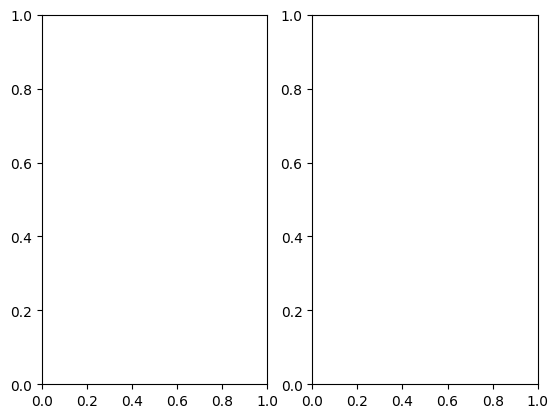

In [15]:
# 初始化绘图环境
fig, axes = plt.subplots(1, 2)

In [16]:
model.load_state_dict(torch.load('./hw_3-Image_Captioning.bin'))

<All keys matched successfully>

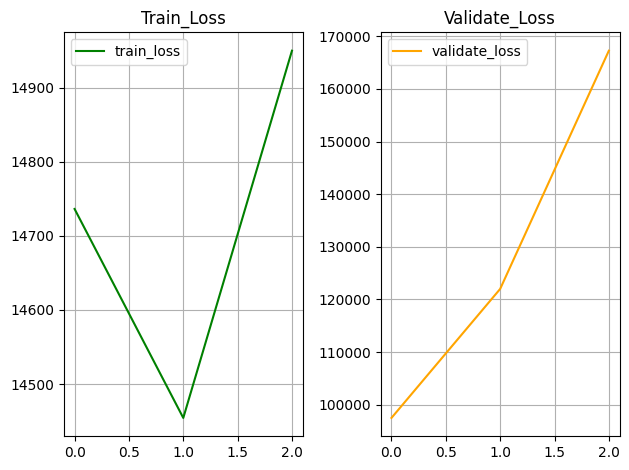

Epoch 2 Train_Loss: 14950.021484375
Epoch 2 Val_Loss: 167253.109375
Finished


In [17]:
%time
epochs = 3
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'
# device = 'cpu'

epoch_loss = []
epoch_loss_val = []

print('训练设备：', device)

model.to(device)
for epoch in range(epochs):
    model.train()
    for X, y in data_loader_train:
        X = X.to(device)
        y_hat = model.forward(X)
        
        l = loss(y, y_hat) / batch_size
        l.backward()
        optimizer.step()

    # 每一代计算测试损失
    model.eval()
    for X_val, y_val in data_loader_val:
        X_val = X_val.to(device)
        y_hat_val = model.forward(X_val)
        
        l_val = loss(y_val, y_hat_val) / batch_size_val
        break
    
    epoch_loss.append(l.cpu().detach().numpy())
    epoch_loss_val.append(l_val.cpu().detach().numpy())
    
    for ax in axes:
        ax.cla() # 清空绘图缓存
        
    axes[0].plot(range(epoch+1), epoch_loss, 'green',label='train_loss')
    axes[1].plot(range(epoch+1), epoch_loss_val, 'orange',label='validate_loss')
    display.clear_output(wait=True) # 清空上一步输出

    axes[0].set_title('Train_Loss')
    axes[1].set_title('Validate_Loss')
    for ax in axes:
        ax.grid()
        ax.legend()

    fig.tight_layout()
    display.display(fig)
    
    print(f'Epoch {epoch} Train_Loss: {l}')
    print(f'Epoch {epoch} Val_Loss: {l_val}')

print('Finished')

In [18]:
# 保存
torch.save(model.state_dict(), './hw_3-Image_Captioning.bin')

tensor([ 0.0000,  0.7616,  0.7616,  0.7616,  0.7616,  0.7616,  0.7616,  0.7616,
         0.7616,  0.7616,  0.7616,  0.7616,  0.7616,  0.7616,  0.7616,  0.7616,
         0.7616,  0.7616,  0.7616,  0.7616,  0.7616,  0.7616,  0.7616,  0.7616,
         0.0000, -0.0000,  0.0000,  0.7616,  0.0000,  0.0000, -0.7616, -0.7616,
        -0.7616, -0.0000,  0.0000,  0.0000,  0.0000,  0.7616,  0.0000,  0.0000,
         0.0000,  0.7616,  0.7616,  0.0000,  0.0000, -0.7616, -0.7616,  0.7616,
         0.0000,  0.7616, -0.0000,  0.0000,  0.0000,  0.0000,  0.7616,  0.0000,
         0.0000, -0.7616,  0.7616, -0.7616, -0.0000,  0.0000,  0.7616, -0.7616,
         0.0000, -0.0000,  0.0000,  0.0000, -0.7616, -0.7616,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.7616,  0.0000,  0.0000,  0.0000,
        -0.7616,  0.0000,  0.7616,  0.0000,  0.0000, -0.7616,  0.7616,  0.0000,
         0.7616,  0.7616,  0.7616,  0.0000, -0.7616, -0.0000,  0.0000,  0.7616,
        -0.7616, -0.7616,  0.7616, -0.76

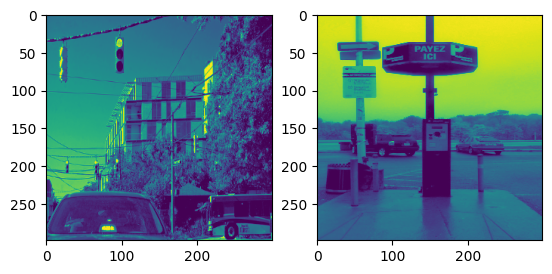

In [20]:
def extractCaption(caption):
    print(caption)
    length = caption.shape[0]
    end = 0
    for i in range(length):
        if caption[i].item() == 102:
            end = i + 1
    caption = caption[:end]
    return caption[1: -1]

fig, axes = plt.subplots(1, 2)
model.eval()
image = []
caption= []
count = 1
for X_val, y_val in data_loader_val:
    s = X_val[0][0]
    image.append(s)
    s = X_val[1][0]
    image.append(s)
    
    
    
    X_val = X_val.to(device)
    y_hat_val = model.forward(X_val)
    
    y_hat_val = y_hat_val.cpu()
    c = y_hat_val[0]
    caption.append(c)
    c = y_hat_val[1]
    caption.append(c)
    # caption[0] = y_hat_val[0]
    # caption[1] = y_hat_val[1]
    
    for i in range(2):
        axes[i].imshow(image[i])
        print(tokenizer.decode(extractCaption(caption[i])))
    
    count += 1
    if count >= 2:
        break
